> **Problem Overview**

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.


In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# import model function from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# import model selection from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# import model evaluation classification metrics from sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
# visualize head of the training data
train_df.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
# visualize tail of the testing data
test_df.tail(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [5]:
# combine training and testing dataframe
train_df['DataType'], test_df['DataType'] = 'training', 'testing'
test_df.insert(1, 'Survived', 0)
data_df = pd.concat([train_df, test_df])
data_df.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DataType
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,training
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,training
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,training


> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [6]:
# describe training and testing data
data_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DataType
count,1309.000000,1309.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,1309
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3,2
top,NaN,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,training
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,891
mean,655.000000,0.261268,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN
std,378.020061,0.439494,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN


In [7]:
# feature extraction: surname
data_df['Surname'] = data_df['Name'].str.extract(r'([A-Za-z]+),', expand=False)

In [8]:
# feature extraction: title
data_df['Title'] = data_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
data_df['Title'] = data_df['Title'].replace(['Capt', 'Rev'], 'Crew')
data_df['Title'] = data_df['Title'].replace('Ms', 'Miss')
data_df['Title'] = data_df['Title'].replace(['Col', 'Countess', 'Don', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Mlle', 'Mme', 'Sir'], 'Royal')

In [9]:
# feature extraction: age
data_df['Age'] = data_df['Age'].fillna(data_df['Age'].mean())

In [10]:
# feature extraction: women and children
data_df['WomenChildren'] = data_df['Sex'].apply(lambda x: 1 if x == 'female' else 0) + data_df['Age'].apply(lambda x: 1 if x <= 16 else 0)
data_df['WomenChildren'] = data_df['WomenChildren'].apply(lambda x: 0 if x == 0 else 1)

In [11]:
# feature extraction: family size
data_df['FamilySize'] = data_df['SibSp'] + data_df['Parch'] + 1

In [12]:
# feature extraction: is alone
data_df['IsAlone'] = data_df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

In [13]:
# feature extraction: ticket string
data_df['TicketString'] = data_df['Ticket'].str.extract(r'([A-Za-z]+)', expand=False)

In [14]:
# feature extraction: has ticket string
data_df['HasTicketString'] = data_df['TicketString'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [15]:
# feature extraction: fare per person
data_df['Fare'] = data_df['Fare'].fillna(0)
data_df['FarePerPerson'] = data_df['Fare'] / data_df['FamilySize']

In [16]:
# feature extraction: has fare
data_df['HasFare'] = data_df['Fare'].apply(lambda x: 0 if x == 0 else 1)

In [17]:
# feature extraction: cabin string
data_df['Cabin'] = data_df['Cabin'].fillna(0)
data_df['CabinString'] = data_df['Cabin'].str.extract(r'([A-Za-z]+)', expand=False)

In [18]:
# feature extraction: has cabin
data_df['HasCabin'] = data_df['CabinString'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [19]:
# feature extraction: embarked
data_df['Embarked'] = data_df['Embarked'].fillna(data_df['Embarked'].value_counts().idxmax())

In [20]:
# feature extraction: tour
data_df['Tour'] = np.where(data_df['FamilySize'] == 1, '-1', data_df['Surname'] + data_df['Ticket'] + data_df['Fare'].apply(lambda x: str(x)))

In [21]:
data_df.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DataType,Surname,Title,WomenChildren,FamilySize,IsAlone,TicketString,HasTicketString,FarePerPerson,HasFare,CabinString,HasCabin,Tour
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,training,Braund,Mr,0,2,0,A,1,3.62500,1,NaN,0,BraundA/5 211717.25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,training,Cumings,Mrs,1,2,0,PC,1,35.64165,1,C,1,CumingsPC 1759971.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,training,Heikkinen,Miss,1,1,1,STON,1,7.92500,1,NaN,0,-1


After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [22]:
# verify dtypes object
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 25 columns):
PassengerId        1309 non-null int64
Survived           1309 non-null int64
Pclass             1309 non-null int64
Name               1309 non-null object
Sex                1309 non-null object
Age                1309 non-null float64
SibSp              1309 non-null int64
Parch              1309 non-null int64
Ticket             1309 non-null object
Fare               1309 non-null float64
Cabin              1309 non-null object
Embarked           1309 non-null object
DataType           1309 non-null object
Surname            1309 non-null object
Title              1309 non-null object
WomenChildren      1309 non-null int64
FamilySize         1309 non-null int64
IsAlone            1309 non-null int64
TicketString       352 non-null object
HasTicketString    1309 non-null int64
FarePerPerson      1309 non-null float64
HasFare            1309 non-null int64
CabinString        295

In [23]:
# convert dtypes object to category
col_obj = data_df.select_dtypes(['object']).columns
data_df[col_obj] = data_df[col_obj].astype('category')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 25 columns):
PassengerId        1309 non-null int64
Survived           1309 non-null int64
Pclass             1309 non-null int64
Name               1309 non-null category
Sex                1309 non-null category
Age                1309 non-null float64
SibSp              1309 non-null int64
Parch              1309 non-null int64
Ticket             1309 non-null category
Fare               1309 non-null float64
Cabin              1309 non-null category
Embarked           1309 non-null category
DataType           1309 non-null category
Surname            1309 non-null category
Title              1309 non-null category
WomenChildren      1309 non-null int64
FamilySize         1309 non-null int64
IsAlone            1309 non-null int64
TicketString       352 non-null category
HasTicketString    1309 non-null int64
FarePerPerson      1309 non-null float64
HasFare            1309 non-null int64
Cabi

In [24]:
# convert dtypes category to category codes
col_cat = data_df.select_dtypes(['category']).columns
data_df[col_cat] = data_df[col_cat].apply(lambda x: x.cat.codes)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 25 columns):
PassengerId        1309 non-null int64
Survived           1309 non-null int64
Pclass             1309 non-null int64
Name               1309 non-null int16
Sex                1309 non-null int8
Age                1309 non-null float64
SibSp              1309 non-null int64
Parch              1309 non-null int64
Ticket             1309 non-null int16
Fare               1309 non-null float64
Cabin              1309 non-null int16
Embarked           1309 non-null int8
DataType           1309 non-null int8
Surname            1309 non-null int16
Title              1309 non-null int8
WomenChildren      1309 non-null int64
FamilySize         1309 non-null int64
IsAlone            1309 non-null int64
TicketString       1309 non-null int8
HasTicketString    1309 non-null int64
FarePerPerson      1309 non-null float64
HasFare            1309 non-null int64
CabinString        1309 non-null in

In [25]:
data_df.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DataType,Surname,Title,WomenChildren,FamilySize,IsAlone,TicketString,HasTicketString,FarePerPerson,HasFare,CabinString,HasCabin,Tour
0,1,0,3,155,1,22.0,1,0,720,7.2500,0,2,1,99,4,0,2,0,0,1,3.62500,1,-1,0,28
1,2,1,1,286,0,38.0,1,0,816,71.2833,107,0,1,189,5,1,2,0,9,1,35.64165,1,2,1,56
2,3,1,3,523,0,26.0,0,0,914,7.9250,0,2,1,338,3,1,1,1,16,1,7.92500,1,-1,0,0


> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

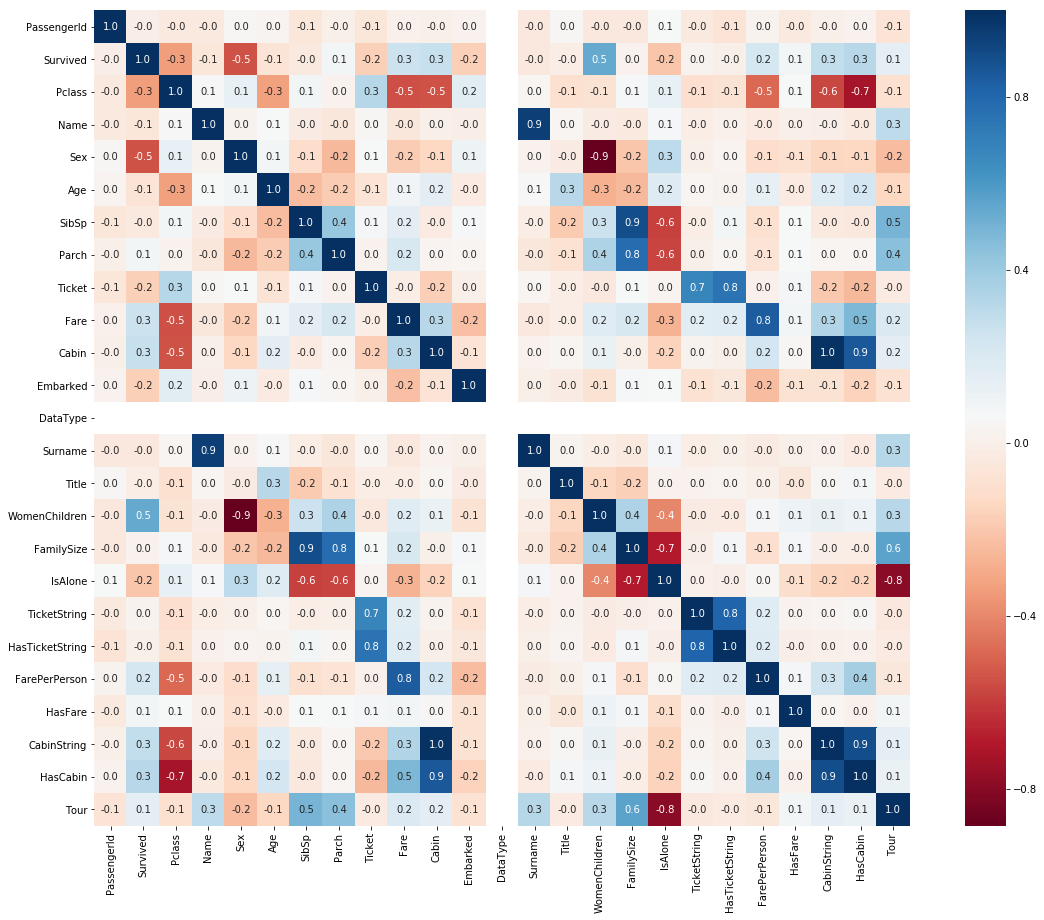

In [26]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = data_df[data_df['DataType'] == 1].corr()
fig, ax = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True);

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


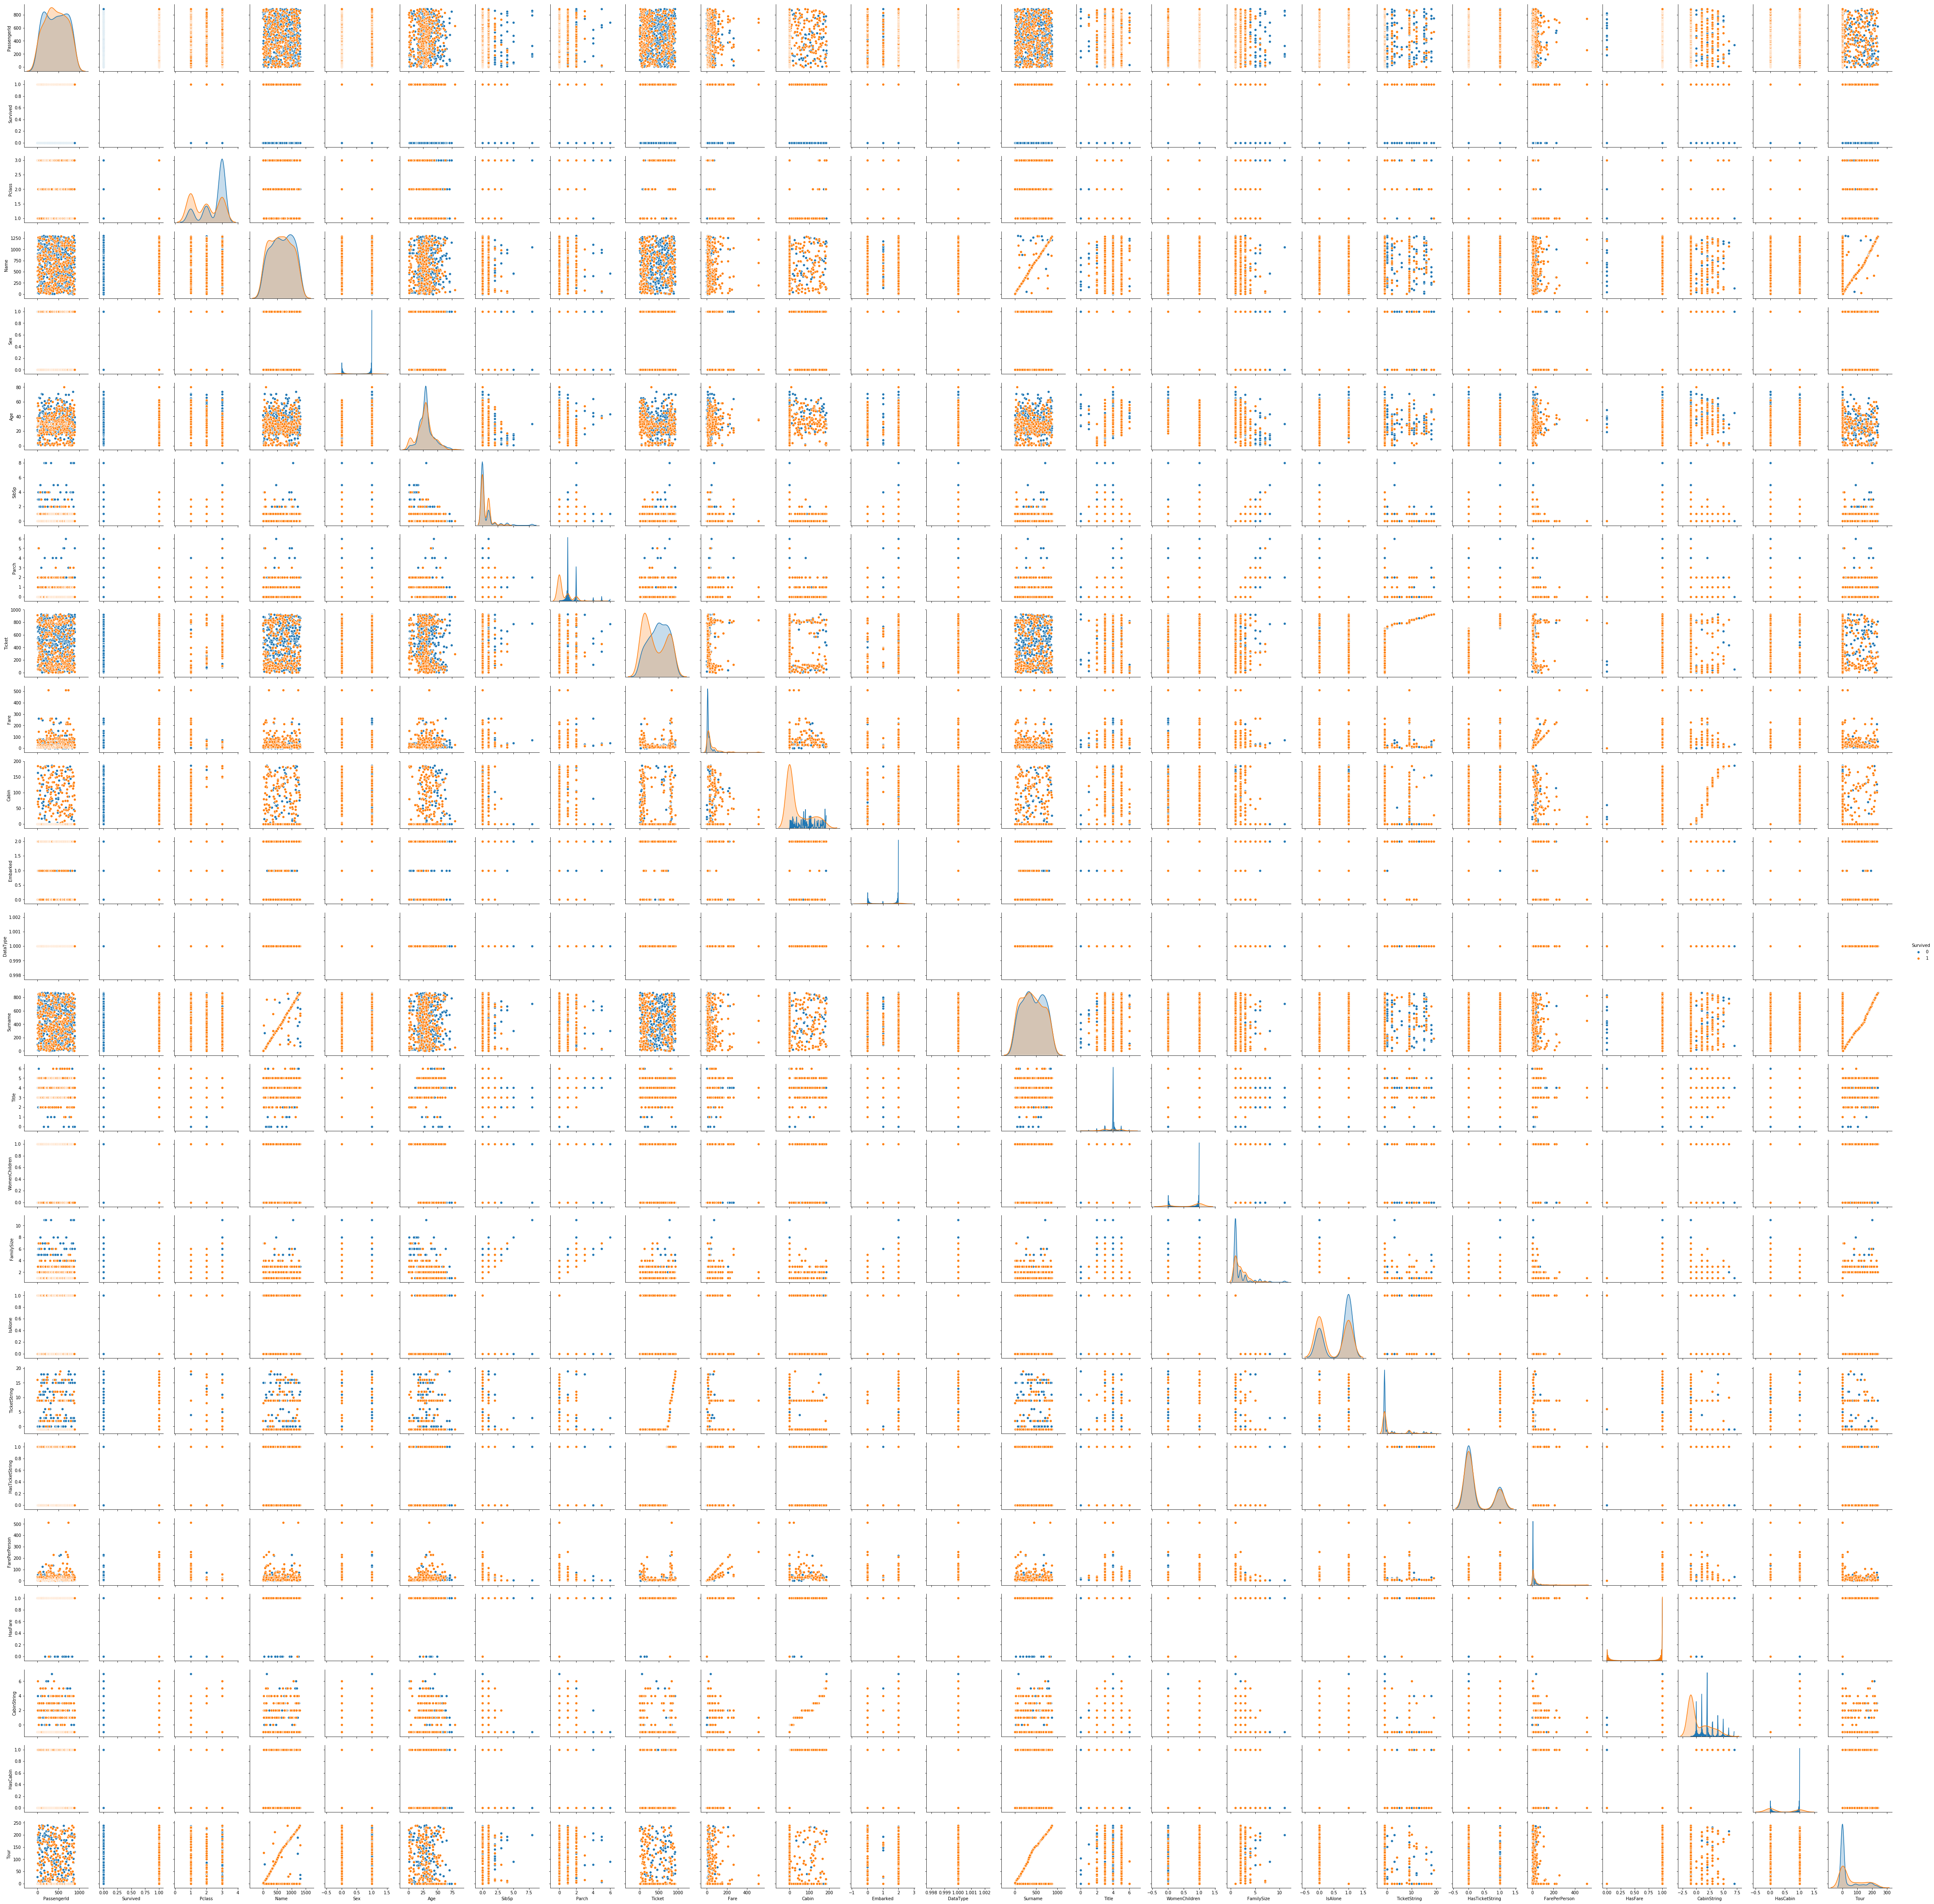

In [27]:
# plot pairwise relationships in a dataset
pairplot = sns.pairplot(data_df[data_df['DataType'] == 1], diag_kind='kde', diag_kws=dict(shade=True), hue='Survived')

The pivot table is also another useful method to observe the impact between features.

In [28]:
# pivot table: women and children in the same tour
pivottable = pd.pivot_table(data_df[(data_df['DataType'] == 1) & (data_df['IsAlone'] == 0)], aggfunc=np.mean,
                            columns=None, index=['WomenChildren', 'Tour'], values='Survived').applymap(lambda x: 1 if x in (0, 1) else 0)
pivottable = pivottable.groupby(level='WomenChildren').mean()
pivottable.style.background_gradient(cmap='Blues')

,Survived
WomenChildren,
0,0.991228
1,0.980263


In [29]:
# pivot table
pivottable = pd.pivot_table(data_df[data_df['DataType'] == 1], aggfunc=np.mean,
                            columns=['Sex'], index=['IsAlone'], values='Survived')
pivottable.style.background_gradient(cmap='Blues')

Sex,0,1
IsAlone,,
0,0.712766,0.271084
1,0.785714,0.155718


> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models

In [30]:
# select all features to evaluate the feature importances
x = data_df[data_df['DataType'] == 1].drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'DataType', 'Surname', 'WomenChildren', 'Tour'], axis=1)
y = data_df[data_df['DataType'] == 1]['Survived']

In [31]:
x.head(n=3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,TicketString,HasTicketString,FarePerPerson,HasFare,CabinString,HasCabin
0,3,1,22.0,1,0,7.2500,2,4,2,0,0,1,3.62500,1,-1,0
1,1,0,38.0,1,0,71.2833,0,5,2,0,9,1,35.64165,1,2,1
2,3,0,26.0,0,0,7.9250,2,3,1,1,16,1,7.92500,1,-1,0


In [32]:
# set up random forest classifier to find the feature importances
forestclf = RandomForestClassifier(max_depth=99, n_estimators=2000, random_state=0).fit(x, y)
feat = pd.DataFrame(data=forestclf.feature_importances_, index=x.columns, columns=['FeatureImportances']).sort_values(['FeatureImportances'], ascending=False)

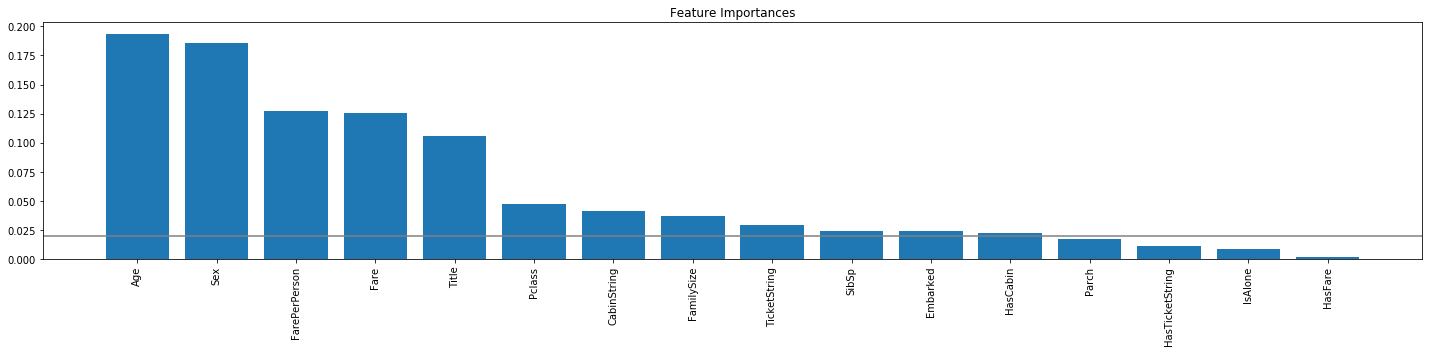

In [33]:
# plot the feature importances
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Feature Importances')
plt.bar(feat.index, feat['FeatureImportances'])
plt.axhline(0.02, color="grey")
ax.set_xticklabels(feat.index, rotation='vertical')
plt.tight_layout()
plt.show()

In [34]:
# list all features
data_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'DataType', 'Surname',
       'Title', 'WomenChildren', 'FamilySize', 'IsAlone', 'TicketString',
       'HasTicketString', 'FarePerPerson', 'HasFare', 'CabinString',
       'HasCabin', 'Tour'],
      dtype='object')

In [35]:
# list feature importances
feat[feat['FeatureImportances'] > 0.02].index

Index(['Age', 'Sex', 'FarePerPerson', 'Fare', 'Title', 'Pclass', 'CabinString',
       'FamilySize', 'TicketString', 'SibSp', 'Embarked', 'HasCabin'],
      dtype='object')

In [36]:
# select the important features
x = data_df[data_df['DataType'] == 1][feat[feat['FeatureImportances'] > 0.02].index]
y = data_df[data_df['DataType'] == 1]['Survived']

In [37]:
x.head(n=3)

,Age,Sex,FarePerPerson,Fare,Title,Pclass,CabinString,FamilySize,TicketString,SibSp,Embarked,HasCabin
0,22.0,1,3.62500,7.2500,4,3,-1,2,0,1,2,0
1,38.0,0,35.64165,71.2833,5,1,2,2,9,1,0,1
2,26.0,0,7.92500,7.9250,3,3,-1,1,16,0,2,0


In [38]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=0, test_size=0.25)

In [39]:
# model prediction
logreg = LogisticRegression().fit(x_train, y_train)
logreg_ypredict = logreg.predict(x_validate)
logreg_f1score, logreg_auc = f1_score(y_validate, logreg_ypredict), roc_auc_score(y_validate, logreg_ypredict)
logreg_cvscores = cross_val_score(logreg, x, y, cv=5, scoring='accuracy')
print('logistic regression\n  f1 score: %0.4f, auc: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(logreg_f1score, logreg_auc, logreg_cvscores.mean(), 2 * logreg_cvscores.std()))

treeclf = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, splitter='best').fit(x_train, y_train)
treeclf_ypredict = treeclf.predict(x_validate)
treeclf_f1score, treeclf_auc = f1_score(y_validate, treeclf_ypredict), roc_auc_score(y_validate, treeclf_ypredict)
treeclf_cvscores = cross_val_score(treeclf, x, y, cv=5, scoring='accuracy')
print('decision tree classifier\n  f1 score: %0.4f, auc: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(treeclf_f1score, treeclf_auc, treeclf_cvscores.mean(), 2 * treeclf_cvscores.std()))

forestclf = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=250, random_state=0).fit(x_train, y_train)
forestclf_ypredict = forestclf.predict(x_validate)
forestclf_f1score, forestclf_auc = f1_score(y_validate, forestclf_ypredict), roc_auc_score(y_validate, forestclf_ypredict)
forestclf_cvscores = cross_val_score(forestclf, x, y, cv=5, scoring='accuracy')
print('random forest classifier\n  f1 score: %0.4f, auc: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(forestclf_f1score, forestclf_auc, forestclf_cvscores.mean(), 2 * forestclf_cvscores.std()))

logistic regression
  f1 score: 0.7456, auc: 0.7959, cross validation score: 0.7901 (+/- 0.0335)
decision tree classifier
  f1 score: 0.7949, auc: 0.8331, cross validation score: 0.8071 (+/- 0.0711)
random forest classifier
  f1 score: 0.8075, auc: 0.8437, cross validation score: 0.8306 (+/- 0.0601)


> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [40]:
# model selection
model = forestclf

# prepare testing data and compute the observed value
x_test = data_df[data_df['DataType'] == 0][feat[feat['FeatureImportances'] > 0.02].index]
y_test = pd.DataFrame(model.predict(x_test), columns=['Survived'])

In [41]:
# summit the results
out = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_test['Survived']})
out.to_csv('submission.csv', index=False)